In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pprint
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import naive_bayes
import seaborn as sns
import math

Будем использовать данные выживших на Титанике

In [2]:
d1 = pd.read_csv('titanic_data.csv')
d2 = pd.read_csv('titanic_surv.csv')
data = pd.concat([d1, d2], axis=1)

In [3]:
data.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [4]:
data.shape

(891, 12)

In [5]:
data.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Survived         int64
dtype: object

Проверим сколько у нас данных отсутсвует и будем решать что делать с ними

In [6]:
data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Survived         0
dtype: int64

<AxesSubplot:>

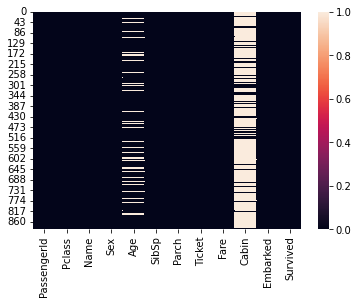

In [7]:
sns.heatmap(data.isnull())

В столбце Cabin много данных пропущено, поэтому просто убираем его

In [8]:
data = data.drop(columns=['Cabin'])

Теперь, основываясь на стандартном отклонении возраста и его среднем значении, заполним пробелы в столбце возраста

In [9]:
mean = data['Age'].mean()
std = data['Age'].std() # стандартное отклонение
number_of_nulls = data['Age'].isnull().sum()
random_ages = np.random.randint(mean - std, mean + std, size=number_of_nulls)

Заменяем пропущенные значения сгенерированными числами

In [10]:
new_ages = data['Age'].copy()
new_ages[np.isnan(new_ages)] = random_ages
data['Age'] = new_ages

<AxesSubplot:>

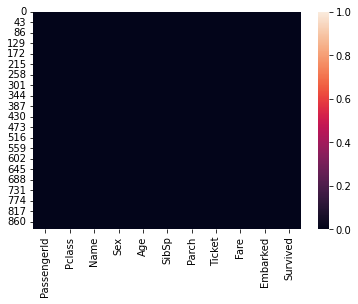

In [11]:
sns.heatmap(data.isnull())

In [12]:
data.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
Survived       0
dtype: int64

Оставшиеся пустые значения просто удалим тк их мало

In [13]:
data = data[data['Embarked'].notnull()]

In [14]:
data.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Survived       0
dtype: int64

Признак Name, скорее всего, не будет полезен при предсказании.
Удалим имена и ID пассажиров а так же их билет

In [15]:
data = data.drop(columns=['Name', 'PassengerId', 'Ticket'])

Чем ниже класс тем более вероятность что человек выживет

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

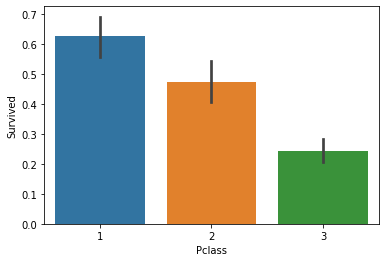

In [17]:
sns.barplot(data=data, x='Pclass', y='Survived')

У женщин, в среднем, вероятность выжить была заметно больше, чем у мужчин

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

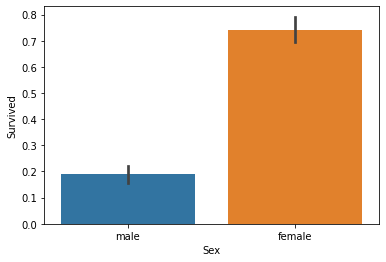

In [18]:
sns.barplot(data=data, x='Sex', y='Survived')

Распределение для выживших и не выживших мужчин и женщин в зависимости от возраста

In [19]:
women_df = data[data['Sex']=='female']
men_df = data[data['Sex']=='male']

Text(0.5, 1.0, 'Male')

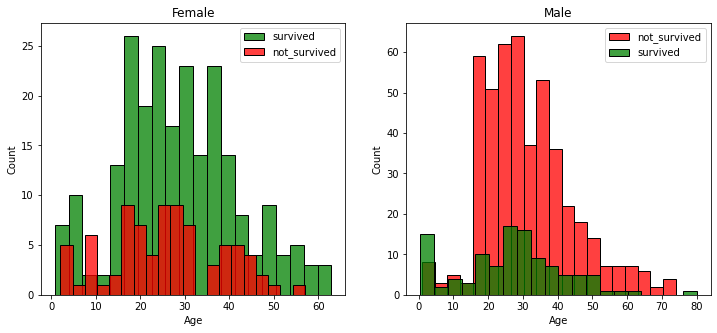

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = sns.histplot(women_df[women_df['Survived']==1]['Age'], bins=20, label='survived', ax = axes[0], color='green')
ax = sns.histplot(women_df[women_df['Survived']==0]['Age'], bins=20, label='not_survived', ax = axes[0], color='red')
ax.legend()
ax.set_title('Female')

ax = sns.histplot(men_df[men_df['Survived']==0]['Age'], bins=20, label='not_survived', ax = axes[1], color='red')
ax = sns.histplot(men_df[men_df['Survived']==1]['Age'], bins=20, label='survived', ax = axes[1], color='green')
ax.legend()
ax.set_title('Male')

Женщины, которые сели в порту S и Q выживали чаще, но чаще погибали, если садились в порту C.
Мужчины имели больший шанс выжить, если сели в порту C, но чаще погибали, если садились в порту S и Q.

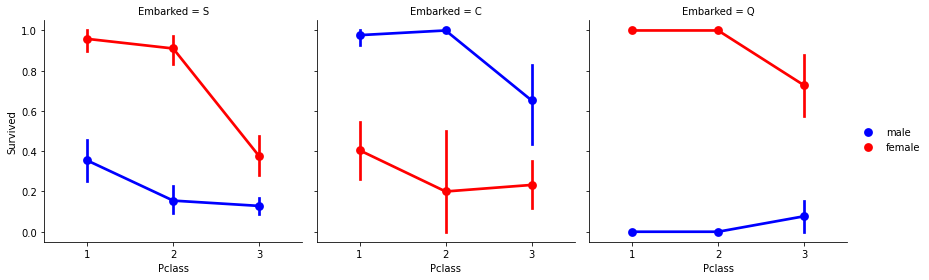

In [21]:
grid = sns.FacetGrid(data, col='Embarked', height=4, aspect=1)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=['blue', 'red'], order=None, hue_order=None )
grid.add_legend()

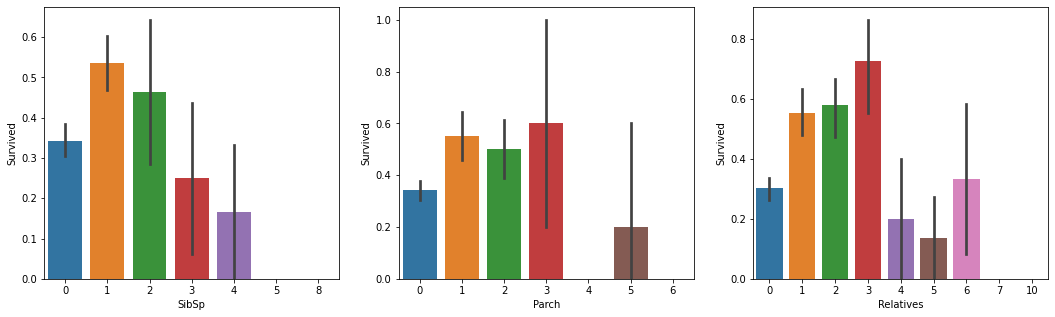

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax = sns.barplot(data=data, x='SibSp', y='Survived', ax=axes[0])
ax = sns.barplot(data=data, x='Parch', y='Survived', ax=axes[1])

data['Relatives'] = data['Parch'] + data['SibSp']
ax = sns.barplot(data=data, x='Relatives', y='Survived', ax=axes[2])
plt.show()

# Мы видим, что, в среднем, люди с 1-3 родственниками на борту выживают чаще. Заменим Parch и SibSp на Relatives для уменьшения количества признаков
data['Relatives'] = data['Parch'] + data['SibSp']
data = data.drop(columns=['SibSp', 'Parch'])

Преобразуем признаки Sex и Embarked

In [23]:
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
data['Embarked'] = data['Embarked'].map({"S": 0, "C": 1, "Q": 2})

Создадим обучающую и тестовые выборки из даты

In [24]:
train, test = train_test_split(data, test_size=0.2)

In [25]:
train.shape, test.shape

((711, 7), (178, 7))

Формируем тренировочные и тестовые данные

In [26]:
x_train = train.drop(columns=['Survived'])
y_train = train['Survived']

In [27]:
x_test = test.drop(columns=['Survived'])
y_test = test['Survived']

## KNN

In [28]:
class KNN:
    def __init__(self,K,x,y):
        self.K = K
        self.x = x.to_numpy()
        self.y = y.to_numpy()
    
    def fit(self,x,y):
        x = x.to_numpy()
        res = []
        err = 0
        for d in range(len(x)):
            dist = []
            # Считаем расстояния от данной точки до всех остальных в дате
            for i in range(len(self.x)):
                dd = [(x[d][idx] - self.x[i][idx])**2 for idx in range(len(self.x[i]))]
                dist.append([sum(dd)**0.5, self.y[i]])   
            dist = sorted(dist)[:self.K]
            inverse_distances = [1/c[0] for c in dist]   
            sum_of_inverses = sum(inverse_distances)
            weights = [[inverse / sum_of_inverses, dist[idx][1]] for idx, inverse in enumerate(inverse_distances)]
            probabilities = {c : 0 for c in y.unique()}
            for elem in weights:
                probabilities[elem[1]] += elem[0]
            res.append(max(probabilities, key=probabilities.get))
            if res[-1] == y.to_numpy()[d]:
                err += 1
        return err / len(y.to_numpy())

In [29]:
model = KNN(3,x_train,y_train)
model.fit(x_test,y_test)

c:\python372\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
c:\python372\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


0.6853932584269663

In [30]:
scores = []
for i in range(2, 50):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    scores.append((y_test == y_pred).sum() / len(y_test))
max(scores)

0.6966292134831461

Нормированная дата

In [31]:
X_train_normalized = x_train.apply(lambda x: (x-x.mean()) / x.std(), axis=0)
X_test_normalized = x_test.apply(lambda x: (x-x.mean()) / x.std(), axis=0)
scores = []
for i in range(2, 100):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train_normalized, y_train)
    Y_pred = knn.predict(X_test_normalized)
    scores.append((y_test == Y_pred).sum() / len(y_test))
max(scores)

0.848314606741573

In [43]:
class NaiveBayesClassifier:
    def __init__(self):
        pass

    def get_probabilities(self, class_idx: int, x: np.array) -> np.array:
        # Считаем вероятность как значение функции плотности нормального распределения в точке x=(p_1,..,p_n)  
    
        # Массив матожиданий и дисперсий для каждого признака при данном классе
        mean = self.mean_cond_class[class_idx]
        var = self.var_cond_class[class_idx]

        # Считаем вероятность для каждого признака, используя плотность вероятности нормального распределения
        exponent = np.exp((-1/2) * ((x-mean)**2) / (2 * var))
        probabilities = exponent / np.sqrt(2 * np.pi * var)
        return probabilities

    # Найдем P(class|p_1,..,p_n)
    def get_posterior(self, x: np.array) -> int:
        posteriors = []
        for class_idx in range(self.num_of_classes):
            prior = np.log(self.prior[class_idx])
            # Условная вероятность получить такие значения признаков для этого класса
            conditional = np.sum(np.log(self.get_probabilities(class_idx, x)))
            posterior = prior + conditionalВ
            posteriors.append(posterior)
        # Возвращаем класс, для которого такая вероятность максимальна
        return self.classes[np.argmax(posteriors)]

    def fit(self, X_train, Y_train):
        self.classes = np.unique(Y_train)
        self.num_of_classes = len(self.classes)
        
        # Посчитаем выборочные средние и дисперсии для каждого признака в зависимости от класса
        self.mean_cond_class = X_train.groupby(Y_train).apply(np.mean).to_numpy()
        self.var_cond_class = X_train.groupby(Y_train).apply(np.var).to_numpy()

        # Считаем для каждого класса, сколько наблюдений принадлежит этому классу
        self.prior = X_train.groupby(Y_train).apply(lambda col: len(col))
        # Находим оценку вероятности того, что случайное наблюдение принадлежит этому классу
        # путём деления результатов на общее количество наблюдений
        self.prior = np.array(self.prior / len(Y_train))
        
    def predict(self, X_test):
        return [self.get_posterior(f) for f in X_test.to_numpy()]
    
    def accuracy_score(self, Y_test, Y_pred):
        return sum(Y_pred == Y_test) / len(Y_test)

In [44]:
nbc = NaiveBayesClassifier()
nbc.fit(x_train, y_train)
y_pred = nbc.predict(x_test)
print(f'Accuracy of custom Naive Bayes: {nbc.accuracy_score(y_test, y_pred)}')

NameError: name 'conditionalВ' is not defined

In [42]:
gaussian = GaussianNB() 
gaussian.fit(x_train, y_train) 
y_pred = gaussian.predict(x_test)  
print(f'Accuracy of sklearn Naive Bayes: {gaussian.score(x_train, y_train)}')

Accuracy of sklearn Naive Bayes: 0.8002812939521801
